0) **Imports**

In [1]:
import os, sys
from timeit import default_timer as timer
import dolfin as df # Fenics : dolfin + ufl + FIAT + ...
import numpy as np

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


1) **Consititutive behaviour Definition**

Strain Energy
$$
\psi(\varepsilon(u)) = \frac{\lambda}{2}
( tr {\varepsilon}^2 + \frac{\alpha}{2} tr {\varepsilon}^4) + 
\mu ( |\varepsilon|^2  + \frac{\alpha}{2} |\varepsilon|^4).
$$

In [44]:
# fetricks is a set of utilitary functions to facilitate our lives
from fetricks.mechanics.elasticity_conversions import youngPoisson2lame
nu = 0.3 
E = 100.0 
alpha = 10e4
lamb, mu = youngPoisson2lame(nu, E)

# alpha : Equivalent to sig = lamb*df.div(u)*df.Identity(2) + mu*(df.grad(u) + df.grad(u).T)
def psi_e(e):
    tr_e = df.tr(e)
    e2 = df.inner(e,e)
    
    return (0.5*lamb*(tr_e**2 + 0.5*alpha*tr_e**4) +
           mu*(e2 + 0.5*alpha*e2**2))

psi = lambda w: psi_e(0.5*(df.grad(w) + df.grad(w).T))

2) **Mesh**  

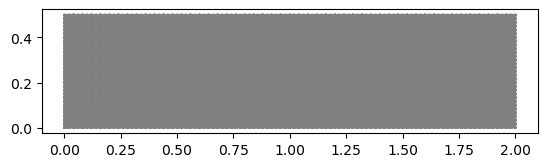

In [35]:
Nx =  100 # x10
Ny =  30 # x10
Lx = 2.0
Ly = 0.5
mesh = df.RectangleMesh(df.Point(0.0,0.0) , df.Point(Lx,Ly), Nx, Ny, 'left/right');
df.plot(mesh);

3) **Mesh regions** 

In [45]:
leftBnd = df.CompiledSubDomain('near(x[0], 0.0) && on_boundary')
rightBnd = df.CompiledSubDomain('near(x[0], Lx) && on_boundary', Lx=Lx)

clampedBndFlag = 1
loadBndFlag = 2
boundary_markers = df.MeshFunction("size_t", mesh, dim=1, value=0)
leftBnd.mark(boundary_markers, clampedBndFlag)
rightBnd.mark(boundary_markers, loadBndFlag)

dx = df.Measure('dx', domain=mesh)
ds = df.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

4) **Spaces**

In [37]:
Uh = df.VectorFunctionSpace(mesh, "CG", 1) # Equivalent to CG
bcL = df.DirichletBC(Uh, df.Constant((0.0, 0.0)), boundary_markers, clampedBndFlag)

5. **Variational Formulation**: Minimisation 
\begin{align} 
\min_{u \in U} \left ( J(u):=\int_{\Omega} \psi(u) dx - \Pi_{ext}(u) \right) \\
F(u; v) = \delta J(u;v) = 0 \quad \forall v \in V , \\
\delta F(u, du; v) = \delta^2 J(u, du;v) \quad \forall v \in V ,
\end{align} 
<br>


In [46]:
du = df.TrialFunction(Uh)            # Incremental displacement
v  = df.TestFunction(Uh)             # Test function
uh  = df.Function(Uh)                 # Displacement from previous iteration

ty = -0.1
traction = df.Constant((0.0, ty))

P_ext = df.inner(traction,uh)*ds(loadBndFlag)
P_int = psi(uh)*dx

J = P_int - P_ext

F = df.derivative(J, uh, v)
DF = df.derivative(F, uh, du) # Optional


6) **Solving**

In [47]:
# Compute solution
start = timer()
df.solve(F == 0, uh, bcL, J = DF)
end = timer()

print("Time spent: ", end - start)
print("Norm L2: ", df.assemble(df.inner(uh,uh)*dx))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time spent:  1.5280645009997897
Norm L2:  0.0004689504257329306


7. **Pos-Processing**

In [48]:
import fetricks.fenics.postprocessing.wrapper_io as iofe

def sigma_law(w):    
    e = 0.5*(df.grad(w) + df.grad(w).T) 
    e = df.variable(e)
    return df.diff(psi_e(e),e)

Sh = df.VectorFunctionSpace(mesh, "DG", 0, dim = 3) 
epsh = df.project( df.as_vector([uh[0].dx(0), uh[1].dx(1), np.sqrt(2)*uh[0].dx(1)]) , Sh)
sig = sigma_law(uh)
sigh = df.project( df.as_vector([sig[0,0], sig[1,1], np.sqrt(2)*sig[0,1]]), Sh)

uh.rename("u",'')
epsh.rename("eps",'')
sigh.rename("sig",'')

iofe.exportXDMF_gen("bar_nonlinear_vtk.xdmf", fields={'vertex': [uh], 'cell_vector': [epsh, sigh] })
iofe.exportXDMF_checkpoint_gen("bar_nonlinear_sol.xdmf", fields={'vertex': [uh], 'cell': [epsh, sigh]})

Calling FFC just-in-time (JIT) compiler, this may take some time.


8. **Checking**


In [49]:
sol_ref_file =  df.XDMFFile("bar_nonlinear_sol.xdmf")
u_ref = df.Function(Uh)

sig_ref = df.Function(Sh)

sol_ref_file.read_checkpoint(u_ref,"u") 
sol_ref_file.read_checkpoint(sig_ref,"sig")

print('error L2 disp', df.assemble( df.inner(uh - u_ref, uh - u_ref)*dx) )
print('error L2 sig', df.assemble( df.inner(sigh - sig_ref, sigh - sig_ref)*dx) )

assert np.allclose(u_ref.vector().get_local()[:], uh.vector().get_local()[:]) 
assert np.allclose(sig_ref.vector().get_local()[:], sigh.vector().get_local()[:]) 

error L2 disp 0.0
error L2 sig 0.0


In [50]:
from ddfenics.dd.ddfunction import DDFunction
from fetricks import symgrad_mandel, tensor2mandel

Sh0 = df.VectorFunctionSpace(mesh, 'DG', degree = 0 , dim = 3) 

epsh = DDFunction(Sh0)
sigh = DDFunction(Sh0)

epsh.update(symgrad_mandel(uh))
sigh.update(tensor2mandel(sig))

sigh.rename('sigma', '')
uh.rename('u', '')

print(np.min(epsh.data(), axis = 0))
print(np.max(epsh.data(), axis = 0))

data = np.concatenate((epsh.data(), sigh.data()), axis = 1)
np.savetxt('database_ref.txt', data, header = '1.0 \n%d 2 3 3'%data.shape[0], comments = '', fmt='%.8e')


print(np.min(epsh.vector().get_local()[0::3]))
print(np.max(epsh.vector().get_local()[0::3]))
print(np.min(epsh.vector().get_local()[1::3]))
print(np.max(epsh.vector().get_local()[1::3]))
print(np.min(epsh.vector().get_local()[2::3]))
print(np.max(epsh.vector().get_local()[2::3]))

Calling FFC just-in-time (JIT) compiler, this may take some time.
[-0.00728806 -0.0019237  -0.00226219]
[0.00728806 0.0019237  0.00023473]
-0.007288063183697368
0.007288063183697367
-0.0019237028613924407
0.0019237028613924402
-0.0022621933348516486
0.00023472509936345364
